In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/RML/HW4

/content/drive/MyDrive/RML/HW4


In [5]:
pwd

'/content/drive/MyDrive/RML/HW4'

In [6]:
! pip install git+https://github.com/airi-industrial-ai/ec23-tutorial -q

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.3/800.3 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 39.3 MB/s eta 0:00:00


In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt
from ectutorial.mnist_utils import *
import numpy as np
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader, Dataset, ConcatDataset

# Task 1

## Generalized to 10 classes

In [8]:
# download MNIST training and testing datasets, then prepare corresponding dataloaders (batch size = 100)
# download MNIST training and testing datasets, then prepare corresponding dataloaders (batch size = 100)
mnist_train = datasets.MNIST("../data", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST("../data", train=False, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(mnist_train, batch_size = 100, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size = 100, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 157636614.46it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 5227675.38it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 93183478.36it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 24708857.03it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Helper function

In [10]:
def gen_colored(image):
    channeled = image.reshape(28, 28, 1)
    weights = [round(i * 0.1, 1) for i in range(1, 11)]
    colors = ['red', 'green', 'blue']

    # Randomly pick a color
    color = random.choice(colors)
    weight = weights[colors.index(color)]

    # Apply the weight to the grayscale intensity
    colored_image = channeled * weight

    return colored_image.reshape(1,28,28)

In [11]:
rr = torchvision.transforms.RandomResizedCrop((28, 28))

In [12]:
# Initialize the new datasets
colored_MNIST = []
grayscaled_MNIST = []
rotated_MNIST = []

# Iterate over the test dataset
for i in range(len(mnist_test)):
    image, _ = mnist_test[i]
    image_np = image.numpy()

    # Generate colored images
    #gs, red, green, blue = gen_colored(image_np)
    colored_image = gen_colored(image_np)
    colored_MNIST.append(colored_image)

    # Generate grayscaled images
    grayscaled_image = weighted_grayscale(image_np, random.choice([0, 1, 2]))
    grayscaled_MNIST.append(grayscaled_image)

    # Generate rotated images
    rotated_image = rr(image).numpy()
    rotated_MNIST.append(rotated_image)

# Convert to numpy arrays
colored_MNIST = np.array(colored_MNIST)
grayscaled_MNIST = np.array(grayscaled_MNIST)
rotated_MNIST = np.array(rotated_MNIST)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [13]:
# Define a new dataset class
class TransformedMNIST(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

# Get the labels from the original test set
labels = mnist_test.targets.numpy()

# Create new datasets
colored_MNIST_dataset = TransformedMNIST(colored_MNIST, labels)
grayscaled_MNIST_dataset = TransformedMNIST(grayscaled_MNIST, labels)
rotated_MNIST_dataset = TransformedMNIST(rotated_MNIST, labels)

In [14]:
# Print the number of examples in each dataset
print(f"Number of examples in colored_MNIST_dataset: {len(colored_MNIST_dataset)}")
print(f"Number of examples in grayscaled_MNIST_dataset: {len(grayscaled_MNIST_dataset)}")
print(f"Number of examples in rotated_MNIST_dataset: {len(rotated_MNIST_dataset)}")

Number of examples in colored_MNIST_dataset: 10000
Number of examples in grayscaled_MNIST_dataset: 10000
Number of examples in rotated_MNIST_dataset: 10000


In [15]:
color_test_loader = DataLoader(colored_MNIST_dataset, batch_size = 100, shuffle=False)
grey_test_loader = DataLoader(grayscaled_MNIST_dataset, batch_size = 100, shuffle=False)
rotated_test_loader = DataLoader(rotated_MNIST_dataset, batch_size = 100, shuffle=False)

# Task 2

### Define the NN model (taken from Assignment 2)

In [16]:
# initialize the CNN architecture with 4 convolutional layers and 2 MLP layers for standard training
torch.manual_seed(0)

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)

In [17]:
def epoch(loader, model, opt=None):
  """Standard training/evaluation epoch over the dataset"""
  criterion = nn.CrossEntropyLoss()
  total_loss = 0.0
  correct = 0
  total_samples = 0

  if opt:
    model.train()
  else:
    model.eval()

  for X,y in loader:
    X = X.to(device)
    # Check if y is an integer and convert to tensor if it is
    if isinstance(y, int):
        y = torch.tensor(y).to(device)
    else:
        y = y.to(device)
    y_pred = model(X)
    loss = criterion(y_pred, y)
    if opt:
      opt.zero_grad()
      loss.backward()
      opt.step()

    total_loss += loss.item()
    _, predicted = y_pred.max(1)
    correct += predicted.eq(y).sum().item()
    total_samples += y.size(0)

  total_error = 1- (correct / total_samples)
  average_loss = total_loss / len(loader)

  return total_error, average_loss


In [18]:
%%time
# Initialize the results
results = {name: [] for name in ['original', 'colored', 'grayscaled', 'rotated']}

# Repeat the experiment 3 times
for i in range(3):
    model_cnn = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(32, 32, 3, padding=1, stride=2), nn.ReLU(),
                          nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(64, 64, 3, padding=1, stride=2), nn.ReLU(),
                          Flatten(),
                          nn.Linear(7*7*64, 100), nn.ReLU(),
                          nn.Linear(100, 10)).to(device)

    model_cnn.to(device)
    opt = optim.SGD(model_cnn.parameters(), lr=0.1)
    # standard training for 30 epochs
    for t in range(30):
        train_err, train_loss = epoch(train_loader, model_cnn, opt)
    print(f"Post training iteration {i}, Train Accuracy: {1-train_err:.6f}")

    # Evaluate the model on each dataset
    for dataset, name in zip([test_loader, color_test_loader, grey_test_loader, rotated_test_loader], ['original', 'colored', 'grayscaled', 'rotated']):
        test_err, test_loss = epoch(dataset, model_cnn)
        print(f"{name} dataset Test Accuracy on iteration {i}: {1-test_err:.6f}")
        results[name].append(1 - test_err)
    print("\n")

Post training iteration 0, Train Accuracy: 1.000000
original dataset Test Accuracy on iteration 0: 0.990300
colored dataset Test Accuracy on iteration 0: 0.982200
grayscaled dataset Test Accuracy on iteration 0: 0.097400
rotated dataset Test Accuracy on iteration 0: 0.459500


Post training iteration 1, Train Accuracy: 0.999317
original dataset Test Accuracy on iteration 1: 0.987100
colored dataset Test Accuracy on iteration 1: 0.985700
grayscaled dataset Test Accuracy on iteration 1: 0.097400
rotated dataset Test Accuracy on iteration 1: 0.454000


Post training iteration 2, Train Accuracy: 1.000000
original dataset Test Accuracy on iteration 2: 0.989800
colored dataset Test Accuracy on iteration 2: 0.985600
grayscaled dataset Test Accuracy on iteration 2: 0.097400
rotated dataset Test Accuracy on iteration 2: 0.457500


CPU times: user 15min 4s, sys: 4.95 s, total: 15min 9s
Wall time: 15min 20s


In [19]:
# Calculate the mean accuracy and standard deviation for each dataset
for name in ['original', 'colored', 'grayscaled', 'rotated']:
    mean_accuracy = np.mean(results[name])
    std_dev = np.std(results[name])
    print(f"{name} test dataset Mean accuracy: {mean_accuracy:.6f}")
    print(f"{name} test datasetStandard deviation: {std_dev:.6f}")
    print("\n")

original test dataset Mean accuracy: 0.989067
original test datasetStandard deviation: 0.001406


colored test dataset Mean accuracy: 0.984500
colored test datasetStandard deviation: 0.001627


grayscaled test dataset Mean accuracy: 0.097400
grayscaled test datasetStandard deviation: 0.000000


rotated test dataset Mean accuracy: 0.457000
rotated test datasetStandard deviation: 0.002273




# Task 3

### Please find the assciated text in the attached PDF

# Task 4

## Augmentation functions for Augmix
We have used the functions from the Augmix library and changed them to be able to augment 1D MNIST tensors (https://github.com/google-research/augmix/tree/master)

In [20]:
from PIL import Image, ImageOps, ImageEnhance

# ImageNet code should change this value
IMAGE_SIZE = 32


def int_parameter(level, maxval):
  """Helper function to scale `val` between 0 and maxval .

  Args:
    level: Level of the operation that will be between [0, `PARAMETER_MAX`].
    maxval: Maximum value that the operation can have. This will be scaled to
      level/PARAMETER_MAX.

  Returns:
    An int that results from scaling `maxval` according to `level`.
  """
  return int(level * maxval / 10)


def float_parameter(level, maxval):
  """Helper function to scale `val` between 0 and maxval.

  Args:
    level: Level of the operation that will be between [0, `PARAMETER_MAX`].
    maxval: Maximum value that the operation can have. This will be scaled to
      level/PARAMETER_MAX.

  Returns:
    A float that results from scaling `maxval` according to `level`.
  """
  return float(level) * maxval / 10.


def sample_level(n):
  return np.random.uniform(low=0.1, high=n)


def autocontrast(pil_img, _):
  return ImageOps.autocontrast(pil_img)


def equalize(pil_img, _):
  return ImageOps.equalize(pil_img)


def posterize(pil_img, level):
  level = int_parameter(sample_level(level), 4)
  return ImageOps.posterize(pil_img, 4 - level)


def rotate(pil_img, level):
  degrees = int_parameter(sample_level(level), 30)
  if np.random.uniform() > 0.5:
    degrees = -degrees
  return pil_img.rotate(degrees, resample=Image.BILINEAR)


def solarize(pil_img, level):
  level = int_parameter(sample_level(level), 256)
  return ImageOps.solarize(pil_img, 256 - level)


def shear_x(pil_img, level):
  level = float_parameter(sample_level(level), 0.3)
  if np.random.uniform() > 0.5:
    level = -level
  return pil_img.transform((IMAGE_SIZE, IMAGE_SIZE),
                           Image.AFFINE, (1, level, 0, 0, 1, 0),
                           resample=Image.BILINEAR)


def shear_y(pil_img, level):
  level = float_parameter(sample_level(level), 0.3)
  if np.random.uniform() > 0.5:
    level = -level
  return pil_img.transform((IMAGE_SIZE, IMAGE_SIZE),
                           Image.AFFINE, (1, 0, 0, level, 1, 0),
                           resample=Image.BILINEAR)


def translate_x(pil_img, level):
  level = int_parameter(sample_level(level), IMAGE_SIZE / 3)
  if np.random.random() > 0.5:
    level = -level
  return pil_img.transform((IMAGE_SIZE, IMAGE_SIZE),
                           Image.AFFINE, (1, 0, level, 0, 1, 0),
                           resample=Image.BILINEAR)


def translate_y(pil_img, level):
  level = int_parameter(sample_level(level), IMAGE_SIZE / 3)
  if np.random.random() > 0.5:
    level = -level
  return pil_img.transform((IMAGE_SIZE, IMAGE_SIZE),
                           Image.AFFINE, (1, 0, 0, 0, 1, level),
                           resample=Image.BILINEAR)


# operation that overlaps with ImageNet-C's test set
def color(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Color(pil_img).enhance(level)


# operation that overlaps with ImageNet-C's test set
def contrast(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Contrast(pil_img).enhance(level)


# operation that overlaps with ImageNet-C's test set
def brightness(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Brightness(pil_img).enhance(level)


# operation that overlaps with ImageNet-C's test set
def sharpness(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Sharpness(pil_img).enhance(level)


augmentations = [
    autocontrast, equalize, posterize, rotate, solarize, shear_x, shear_y,
    translate_x, translate_y
]

augmentations_all = [
    autocontrast, equalize, posterize, rotate, solarize, shear_x, shear_y,
    translate_x, translate_y, color, contrast, brightness, sharpness
]

In [21]:
def normalize(tensor):
    """Normalize input tensor channel-wise to zero mean and unit variance."""
    tensor = tensor.clone().detach()
    mean, std = torch.tensor(0.1307), torch.tensor(0.3081)
    tensor = (tensor - mean) / std
    return tensor

def apply_op(tensor, op, severity):
    """Apply an augmentation operation to a tensor."""
    tensor = tensor.clone().detach()
    tensor = tensor.mul(255).byte()  # Convert to 8-bit for PIL
    pil_img = TF.to_pil_image(tensor)  # Convert to PIL.Image
    pil_img = op(pil_img, severity)
    tensor = TF.to_tensor(pil_img)  # Convert back to tensor
    return tensor

def augment_and_mix(image, seed, severity=3, width=3, depth=-1, alpha=1.):
    """Perform AugMix augmentations and compute mixture.

    Args:
        image: Raw input image as PyTorch tensor of shape (c, h, w)
        severity: Severity of underlying augmentation operators (between 1 to 10).
        width: Width of augmentation chain
        depth: Depth of augmentation chain. -1 enables stochastic depth uniformly
          from [1, 3]
        alpha: Probability coefficient for Beta and Dirichlet distributions.
        seed: Seed for the random number generator.

    Returns:
        mixed: Augmented and mixed image.
    ## Used the default parameters in this implementation
    """
    np.random.seed(seed)
    torch.manual_seed(seed)

    ws = torch.tensor(np.random.dirichlet([alpha] * width))
    m = torch.tensor(np.random.beta(alpha, alpha))

    mix = torch.zeros_like(image)
    for i in range(width):
        image_aug = image.clone()
        d = depth if depth > 0 else np.random.randint(1, 4)
        for _ in range(d):
            op = np.random.choice(augmentations_all)
            image_aug = apply_op(image_aug, op, severity)
        image_aug = TF.resize(image_aug, [28, 28])  # Resize back to 28x28
        mix += ws[i] * normalize(image_aug)

    mixed = (1 - m) * normalize(image) + m * mix
    return mixed

In [22]:
%%time
# Initialize an empty list to hold the augmented data
augmented_data = []

# Apply augment_and_mix to each image in the dataset
for i,data in enumerate(mnist_train):
    image, label = data
    augmented_image = augment_and_mix(image,seed=i)
    augmented_data.append((augmented_image, label))

augmented_dataloader = DataLoader(augmented_data, batch_size=100, shuffle=True)
augmented_dataset = augmented_dataloader.dataset

CPU times: user 2min 45s, sys: 1e+03 ms, total: 2min 46s
Wall time: 2min 47s


#### View the augmented MNIST images

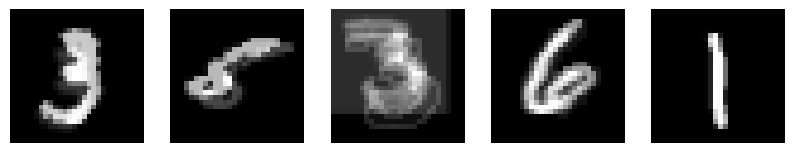

In [23]:
# Select the first 5 images from the augmented dataset
images = [img for img, _ in list(augmented_dataset)[10:15]]

# Create a new figure
plt.figure(figsize=(10, 2))

for i, image in enumerate(images):
    # Convert the tensor to a numpy array
    image = image.numpy().squeeze()

    # Create a subplot for each image
    plt.subplot(1, 5, i+1)
    plt.imshow(image, cmap='gray')
    plt.axis('off')

# Display the plot
plt.show()

In [24]:
# Combine the original and augmented datasets
combined_dataset = ConcatDataset([mnist_train, augmented_dataset])

augmented_train_loader = DataLoader(combined_dataset, batch_size = 100, shuffle=True)

## Load the MNIST-C testset
Please note that we have downloaded the MNIST-C datasets for motion blur, fog and zig-zag and we load them here from gdrive, so it is advisable to check the paths when running this block

In [26]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import os

# Define the corruption types
corruptions = ['motion_blur', 'fog', 'zigzag']

# Get the current working directory
current_path = os.getcwd()

# Create a dictionary to hold the DataLoaders for each corruption type
dataloaders = {}

for corruption in corruptions:
    # Construct the path to the corruption folder within the current directory
    path_to_corruption = os.path.join(current_path, corruption)

    # Load images and labels
    images = np.load(os.path.join(path_to_corruption, 'test_images.npy'))
    labels = np.load(os.path.join(path_to_corruption, 'test_labels.npy'))

    # Convert to PyTorch tensors and transpose the dimensions
    images_tensor = torch.tensor(images, dtype=torch.float32).permute(0, 3, 1, 2)
    labels_tensor = torch.tensor(labels, dtype=torch.long)

    # Create TensorDataset
    dataset = TensorDataset(images_tensor, labels_tensor)

    # Create the DataLoader
    dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

    # Store the DataLoader in the dictionary
    dataloaders[corruption] = dataloader

In [27]:
# initialize the CNN architecture with 4 convolutional layers and 2 MLP layers for standard training
torch.manual_seed(0)

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)

model_cnn_aug = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(32, 32, 3, padding=1, stride=2), nn.ReLU(),
                          nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(64, 64, 3, padding=1, stride=2), nn.ReLU(),
                          Flatten(),
                          nn.Linear(7*7*64, 100), nn.ReLU(),
                          nn.Linear(100, 10)).to(device)

In [29]:
import torch.optim as optim
from tqdm import tqdm
# Specify the optimizer as SGD
opt = optim.SGD(model_cnn_aug.parameters(), lr=0.1)

# Standard training for 30 epochs on augmented data
for t in tqdm(range(30)):
    train_err, train_loss = epoch(augmented_train_loader, model_cnn_aug, opt)
    if (t+1)%5 == 0:
      print(f"Epoch {t+1}, Train Accuracy: {1-train_err:.6f}")

 17%|█▋        | 5/30 [01:01<05:02, 12.09s/it]

Epoch 5, Train Accuracy: 0.994250


 33%|███▎      | 10/30 [02:03<04:03, 12.16s/it]

Epoch 10, Train Accuracy: 0.998683


 50%|█████     | 15/30 [03:03<03:00, 12.04s/it]

Epoch 15, Train Accuracy: 0.999817


 67%|██████▋   | 20/30 [04:03<02:00, 12.10s/it]

Epoch 20, Train Accuracy: 0.999867


 83%|████████▎ | 25/30 [05:03<01:00, 12.04s/it]

Epoch 25, Train Accuracy: 1.000000


100%|██████████| 30/30 [06:04<00:00, 12.15s/it]

Epoch 30, Train Accuracy: 1.000000


In [30]:
# Initialize the results
results_aug = {}

# Evaluate the model on each corrupted dataset
for corruption, dataloader in dataloaders.items():
    test_err, test_loss = epoch(dataloader, model_cnn)
    accuracy = 1 - test_err
    test_err_aug, test_loss_aug = epoch(dataloader, model_cnn_aug)
    accuracy_aug = 1 - test_err_aug
    print(f"Clean model Test Accuracy on {corruption}: {accuracy:.6f}")
    print(f"Augmented model Test Accuracy on {corruption}: {accuracy_aug:.6f}")
    print(f"\n")

    results[corruption] = accuracy  # Store accuracy
    results_aug[corruption] = accuracy_aug  # Store accuracy

Clean model Test Accuracy on motion_blur: 0.948300
Augmented model Test Accuracy on motion_blur: 0.963200


Clean model Test Accuracy on fog: 0.556900
Augmented model Test Accuracy on fog: 0.866500


Clean model Test Accuracy on zigzag: 0.911100
Augmented model Test Accuracy on zigzag: 0.899100




# Original tutorial (for 0's and 8's)

For example, let's consider the MNIST dataset and select only 0s and 8s to train a classifier.

In [ ]:
zeros.shape

In [ ]:
zeros, eights, rotated_zeros, rotated_eights = get_mnist_0_and_8()

Here are some random examples of numbers.

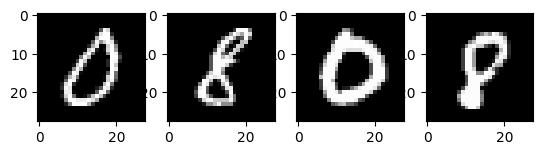

In [ ]:
vis_random(zeros, eights)

Let's convert them into vectors in order to train a Random Forest model.

In [ ]:
X, y = gen_sample(zeros, eights)

In [ ]:
zeros[0].shape, len(X[0])

((28, 28), 784)

In [ ]:
y[:10]

array([0., 1., 0., 1., 1., 0., 0., 0., 1., 1.])

And finally, train the model.

In [ ]:
rfc = RandomForestClassifier()
rfc.fit(X[:X.shape[0] // 2], y[:X.shape[0] // 2])
preds_val = rfc.predict_proba(X[X.shape[0] // 2:])[:, 1]

print(f"""
ROC-AUC Val: {roc_auc_score(y[X.shape[0] // 2:], preds_val)}
""")


ROC-AUC Val: 0.9997213671400944



Let's introduce color to MNIST dataset. Suppose that 0s will be represented in red, and 8s will be represented in green during the training phase. The performance of the model should not depend on the color of the number, as only the shape should be considered. We are still working with one channel, but we assign different weights to it based on the color: red has a weight of 0.3, green has a weight of 0.59, and blue has a weight of 0.11.

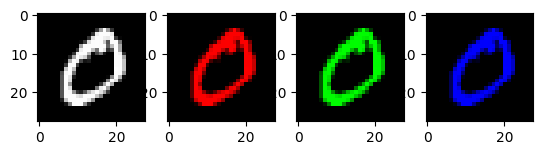

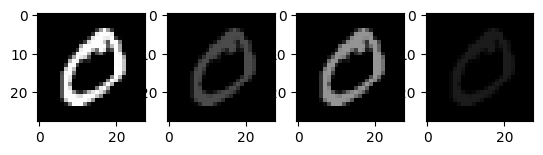

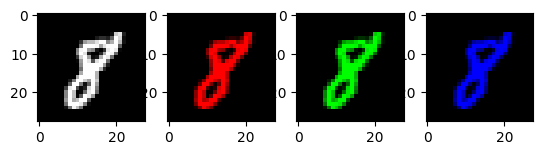

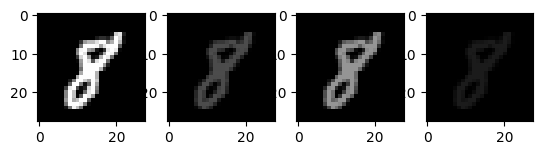

In [ ]:
vis_colored(zeros[0])
vis_grayscale(zeros[0])
vis_colored(eights[0])
vis_grayscale(eights[0])

The different colors have different intensities when converted to grayscale.

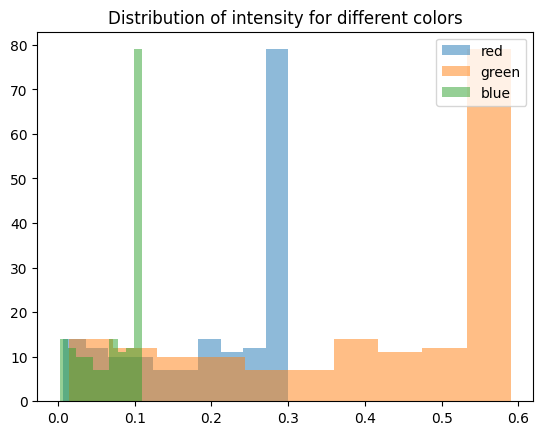

In [ ]:
vis_zero_hist(zeros)

Let's generate different splits.

In [ ]:
splits = gen_colored_splits(zeros, eights)
splits.keys()

dict_keys(['train', 'train_flipped', 'val', 'test', 'blue'])


Let's evaluate the performance on the same type of data.

In [ ]:
rfc = RandomForestClassifier()
rfc.fit(*splits["train"])

X_val, y_val = splits["val"]
preds_val = rfc.predict_proba(X_val)[:, 1]

print(f"""
ROC-AUC Val: {roc_auc_score(y_val, preds_val)}
""")


ROC-AUC Val: 1.0



What if our training data does not contain a certain type of observations?

It is a data distribution shift. Our model has not encountered novel data, so it cannot make proper decisions.

For example, we can switch colors between 0s and 8s.

In [ ]:
X_test, y_test = splits["test"]
preds_test = rfc.predict_proba(X_test)[:, 1]

print(f"""
ROC-AUC Test: {roc_auc_score(y_test, preds_test)}
""")


ROC-AUC Test: 0.08618909644917713



Our model has overfitted to the colors and has not learned anything about shapes.

The fundamental solution is to increase the diversity of the data and ensure that it can generalize to any situation.

In [ ]:
X = np.concatenate([splits["train"][0], splits["train_flipped"][0]])
y = np.concatenate([splits["train"][1], splits["train_flipped"][1]])

rfc = RandomForestClassifier()
rfc.fit(X, y)

preds_val = rfc.predict_proba(X_val)[:, 1]
preds_test = rfc.predict_proba(X_test)[:, 1]

print(f"""
ROC-AUC Val: {roc_auc_score(y_val, preds_val)}
ROC-AUC Test: {roc_auc_score(y_test, preds_test)}
""")


ROC-AUC Val: 0.9996288444335226
ROC-AUC Test: 0.9995615841884935



Now it works much better and can even generalize to new colors.

In [ ]:
X_blue, y_blue = splits["blue"]
preds_blue = rfc.predict_proba(X_blue)[:, 1]

print(f"""
ROC-AUC Test Blue: {roc_auc_score(y_blue, preds_blue)}
""")


ROC-AUC Test Blue: 0.9987825618672601



However, there are limitations to our ability to handle data distribution shifts.

It is possible that we have not considered all possible types of observations (e.g., random crops).

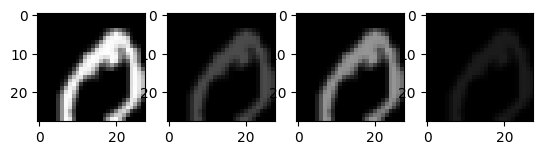

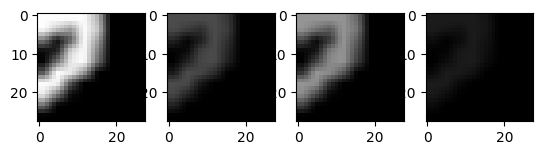

In [ ]:
vis_grayscale(rotated_zeros[0])
vis_grayscale(rotated_eights[0])

In [ ]:
X, y = gen_sample(rotated_zeros, rotated_eights)

preds_rotated = rfc.predict_proba(X)[:, 1]

print(f"""
ROC-AUC Test Blue: {roc_auc_score(y, preds_rotated)}
""")


ROC-AUC Test Blue: 0.45627517477542434

